# XGBoost Model with Expanding Mean

In [1]:
import pandas as pd
import numpy as np
from itertools import product
import xgboost as xgb
import pickle
import gc

In [2]:
# Choose number of lags to be used for the model

lags=[1,2,3,4,5,6,7,8,9,10,11,12]

In [2]:
sales = pd.read_csv('data/sales_train_v2.csv')
items = pd.read_csv('data/items.csv')
item_categories = pd.read_csv('data/item_categories.csv')
shops = pd.read_csv('data/shops.csv')
test = pd.read_csv('data/test.csv')

In [3]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [4]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    # all unique shop id for the block_num month
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    # all unique item id for the block_num month
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    # append cartesian product of all unique shop id and item id that occur in  block_num month
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [5]:
# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum','item_price': np.mean})
# Rename item_cnt_day column as target
gb.rename({'item_cnt_day':'target'}, axis='columns',inplace=True)

In [6]:
# Join it to the grid
# Any shop/item combinations with no target means it has no sale, so fill with 0
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)
# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
all_data.head()

,shop_id,item_id,date_block_num,target,item_price
0,59,22154,0,1.0,999.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0


In [7]:
# Generate test data
# Test month is 34
test['date_block_num'] = 34
test.drop(columns=['ID'], inplace=True)
test = downcast_dtypes(test)
test.head()# Delete grid and gb to save memory

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [8]:
# Delete grid and gb to save memory
del grid,gb
gc.collect()

56

In [9]:
# Add revenue
all_data['revenue'] = all_data['target'] * all_data['item_price']

In [10]:
all_data = pd.merge(all_data, items, how='left', on='item_id')
all_data = pd.merge(all_data, item_categories, how='left', on='item_category_id')
all_data = pd.merge(all_data, shops, how='left', on='shop_id')

In [11]:
# drop item_name, item_category_name and shop_name
# Unlikely to have sufficient memory to utilise these feature
all_data.drop(columns=['item_name','item_category_name','shop_name'],inplace=True)
# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
all_data.head()

,shop_id,item_id,date_block_num,target,item_price,revenue,item_category_id
0,59,22154,0,1.0,999.0,999.0,37
1,59,2552,0,0.0,0.0,0.0,58
2,59,2554,0,0.0,0.0,0.0,58
3,59,2555,0,0.0,0.0,0.0,56
4,59,2564,0,0.0,0.0,0.0,59


In [12]:
test = pd.merge(test, items, how='left', on='item_id')
test = pd.merge(test, item_categories, how='left', on='item_category_id')
test = pd.merge(test, shops, how='left', on='shop_id')

In [13]:
test.drop(columns=['item_name','item_category_name','shop_name'],inplace=True)
test = downcast_dtypes(test)
test.head()

,shop_id,item_id,date_block_num,item_category_id
0,5,5037,34,19
1,5,5320,34,55
2,5,5233,34,19
3,5,5232,34,23
4,5,5268,34,20


In [14]:
print("Missing Values per Column For all_data")
all_data.isnull().mean()

Missing Values per Column For all_data


shop_id             0.0
item_id             0.0
date_block_num      0.0
target              0.0
item_price          0.0
revenue             0.0
item_category_id    0.0
dtype: float64

In [15]:
print("Missing Values per Column For test")
test.isnull().mean()

Missing Values per Column For test


shop_id             0.0
item_id             0.0
date_block_num      0.0
item_category_id    0.0
dtype: float64

In [16]:
# add 0 to test price, target and revenue temporarily to creat mean encodings. WIll drop them later
test.insert(loc=3, column='target', value=0)
test.insert(loc=4, column='item_price', value=0)
test.insert(loc=5, column='revenue', value=0)
test.head()

,shop_id,item_id,date_block_num,target,item_price,revenue,item_category_id
0,5,5037,34,0,0,0,19
1,5,5320,34,0,0,0,55
2,5,5233,34,0,0,0,19
3,5,5232,34,0,0,0,23
4,5,5268,34,0,0,0,20


In [17]:
combined_data = pd.concat([all_data,test],axis=0)
combined_data.head()

,shop_id,item_id,date_block_num,target,item_price,revenue,item_category_id
0,59,22154,0,1.0,999.0,999.0,37
1,59,2552,0,0.0,0.0,0.0,58
2,59,2554,0,0.0,0.0,0.0,58
3,59,2555,0,0.0,0.0,0.0,56
4,59,2564,0,0.0,0.0,0.0,59


# Add mean encodings

Exapnding mean will be the method used to perform mean encodings for this model. The target, item_price and revenue will be grouped by shop_id and item_id. Other groupings were also tried, such as group by item_id only, shopi_only, etc., but the performance is usually not as good.

In [18]:
#cumsum = combined_data.groupby(['item_id'])['target'].cumsum() - all_data['target']
#cumsum

0              0.0
0           1269.0
1              0.0
1              0.0
2              0.0
2            507.0
3              0.0
3            141.0
4              0.0
4              0.0
5              0.0
5           1041.0
6              0.0
6            311.0
7              0.0
7            553.0
8              0.0
8           1685.0
9              0.0
9            107.0
10             0.0
10          3532.0
11             0.0
11           279.0
12             0.0
12           528.0
13             0.0
13           969.0
14             0.0
14          7551.0
             ...  
10913820      34.0
10913821      61.0
10913822      11.0
10913823      23.0
10913824    1016.0
10913825      83.0
10913826      51.0
10913827      17.0
10913828       6.0
10913829       1.0
10913830       5.0
10913831      71.0
10913832     167.0
10913833     129.0
10913834      17.0
10913835      14.0
10913836      42.0
10913837     375.0
10913838       2.0
10913839       3.0
10913840       1.0
10913841    

In [19]:
#len(cumsum)

11128050

In [20]:
# Add mean encodings to train
col_to_enc = [['item_id','shop_id']]

val_to_enc = [['target'],['item_price'],['revenue']]

# For keeping track of progress of code running
progress_counter = 0
total_processes = len(col_to_enc) * len(val_to_enc)

for col in col_to_enc:
    for val in val_to_enc:
        cumsum = combined_data.groupby(col)[val[0]].cumsum() - combined_data[val[0]]
        cumcnt = combined_data.groupby(col).cumcount()
        enc_col_name = "mean_of_"+val[0]+"_groupby_"+"_".join(col)
        combined_data[enc_col_name] = cumsum/cumcnt
        progress_counter += 1
        print("Current progress: " +str(progress_counter)+"/"+str(total_processes))

Current progress: 1/3
Current progress: 2/3
Current progress: 3/3


In [22]:
combined_data.head()

,shop_id,item_id,date_block_num,target,item_price,revenue,item_category_id,mean_of_target_groupby_item_id_shop_id,mean_of_item_price_groupby_item_id_shop_id,mean_of_revenue_groupby_item_id_shop_id
0,59,22154,0,1.0,999.0,999.0,37,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,0.0,58,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,0.0,58,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,0.0,56,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,0.0,59,NaN,NaN,NaN


In [23]:
# replace any inf with nan if any
combined_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [24]:
combined_data.isnull().mean()

shop_id                                       0.00000
item_id                                       0.00000
date_block_num                                0.00000
target                                        0.00000
item_price                                    0.00000
revenue                                       0.00000
item_category_id                              0.00000
mean_of_target_groupby_item_id_shop_id        0.10355
mean_of_item_price_groupby_item_id_shop_id    0.10355
mean_of_revenue_groupby_item_id_shop_id       0.10355
dtype: float64

In [25]:
combined_data = downcast_dtypes(combined_data)

In [26]:
del all_data, test
gc.collect()

28

# Add lags

Add lags of mean encodings of target, item_price and revenue grouped by item_id and shop_id. Currently applying lags of 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 months.

In [27]:
#lags=[1,2,3,4,5,6,7,8,9,10,11,12]

In [28]:
def create_lag_features(lags, features, df):
    
    # For keeping track of progress of code running
    progress_counter = 0
    total_processes = len(lags)
    
    for lag in lags:
        df_copy = df[['date_block_num', 'shop_id', 'item_id'] + features].copy()
        #df_copy = df_copy[['date_block_num'] + group_on + features]
        df_copy['date_block_num'] += lag
        df_copy.rename({feat: feat+"_"+str(lag)+'_months_ago' for feat in features},\
                       axis=1, inplace=True)
        df = pd.merge(df, df_copy, on=['date_block_num', 'shop_id', 'item_id'], how='left')
        progress_counter += 1
        print("Current progress: " +str(progress_counter)+"/"+str(total_processes))
    return df

In [29]:
features= ['mean_of_target_groupby_item_id_shop_id','mean_of_item_price_groupby_item_id_shop_id',\
           'mean_of_revenue_groupby_item_id_shop_id']

combined_data = create_lag_features(lags, features, combined_data)
combined_data = downcast_dtypes(combined_data)
combined_data.head()

Current progress: 1/12
Current progress: 2/12
Current progress: 3/12
Current progress: 4/12
Current progress: 5/12
Current progress: 6/12
Current progress: 7/12
Current progress: 8/12
Current progress: 9/12
Current progress: 10/12
Current progress: 11/12
Current progress: 12/12


,shop_id,item_id,date_block_num,target,item_price,revenue,item_category_id,mean_of_target_groupby_item_id_shop_id,mean_of_item_price_groupby_item_id_shop_id,mean_of_revenue_groupby_item_id_shop_id,...,mean_of_revenue_groupby_item_id_shop_id_9_months_ago,mean_of_target_groupby_item_id_shop_id_10_months_ago,mean_of_item_price_groupby_item_id_shop_id_10_months_ago,mean_of_revenue_groupby_item_id_shop_id_10_months_ago,mean_of_target_groupby_item_id_shop_id_11_months_ago,mean_of_item_price_groupby_item_id_shop_id_11_months_ago,mean_of_revenue_groupby_item_id_shop_id_11_months_ago,mean_of_target_groupby_item_id_shop_id_12_months_ago,mean_of_item_price_groupby_item_id_shop_id_12_months_ago,mean_of_revenue_groupby_item_id_shop_id_12_months_ago
0,59,22154,0,1.0,999.0,999.0,37,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,0.0,0.0,58,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,0.0,0.0,58,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,0.0,56,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,0.0,0.0,59,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# remove first 12 months (0 to 11) since there will be alot of NaNs
combined_data = combined_data[combined_data['date_block_num'] > 11]
combined_data.head()

,shop_id,item_id,date_block_num,target,item_price,revenue,item_category_id,mean_of_target_groupby_item_id_shop_id,mean_of_item_price_groupby_item_id_shop_id,mean_of_revenue_groupby_item_id_shop_id,...,mean_of_revenue_groupby_item_id_shop_id_9_months_ago,mean_of_target_groupby_item_id_shop_id_10_months_ago,mean_of_item_price_groupby_item_id_shop_id_10_months_ago,mean_of_revenue_groupby_item_id_shop_id_10_months_ago,mean_of_target_groupby_item_id_shop_id_11_months_ago,mean_of_item_price_groupby_item_id_shop_id_11_months_ago,mean_of_revenue_groupby_item_id_shop_id_11_months_ago,mean_of_target_groupby_item_id_shop_id_12_months_ago,mean_of_item_price_groupby_item_id_shop_id_12_months_ago,mean_of_revenue_groupby_item_id_shop_id_12_months_ago
4488756,54,10297,12,4.0,749.0,2996.0,37,1.500000,374.500000,1123.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4488757,54,10296,12,3.0,1599.0,4797.0,38,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4488758,54,10298,12,14.0,399.0,5586.0,40,49.000000,395.666656,19527.666016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4488759,54,10300,12,3.0,699.0,2097.0,37,10.666667,464.333344,7404.333496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4488760,54,10284,12,1.0,299.0,299.0,57,0.300000,89.699997,89.699997,...,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
combined_data.isnull().mean()

shop_id                                                     0.000000
item_id                                                     0.000000
date_block_num                                              0.000000
target                                                      0.000000
item_price                                                  0.000000
revenue                                                     0.000000
item_category_id                                            0.000000
mean_of_target_groupby_item_id_shop_id                      0.062445
mean_of_item_price_groupby_item_id_shop_id                  0.062445
mean_of_revenue_groupby_item_id_shop_id                     0.062445
mean_of_target_groupby_item_id_shop_id_1_months_ago         0.255750
mean_of_item_price_groupby_item_id_shop_id_1_months_ago     0.255750
mean_of_revenue_groupby_item_id_shop_id_1_months_ago        0.255750
mean_of_target_groupby_item_id_shop_id_2_months_ago         0.284931
mean_of_item_price_groupby_item_id

In [32]:
# Try to fill missing data with previous months' mean encodings. If that is not possible, fill with 0. 
combined_data['mean_of_target_groupby_item_id_shop_id_12_months_ago'] = combined_data['mean_of_target_groupby_item_id_shop_id_12_months_ago'].fillna(0)
combined_data['mean_of_item_price_groupby_item_id_shop_id_12_months_ago'] = combined_data['mean_of_item_price_groupby_item_id_shop_id_12_months_ago'].fillna(0)
combined_data['mean_of_revenue_groupby_item_id_shop_id_12_months_ago'] = combined_data['mean_of_revenue_groupby_item_id_shop_id_12_months_ago'].fillna(0)

combined_data['mean_of_target_groupby_item_id_shop_id_11_months_ago'] = combined_data['mean_of_target_groupby_item_id_shop_id_11_months_ago'].fillna(combined_data['mean_of_target_groupby_item_id_shop_id_12_months_ago'])
combined_data['mean_of_item_price_groupby_item_id_shop_id_11_months_ago'] = combined_data['mean_of_item_price_groupby_item_id_shop_id_11_months_ago'].fillna(combined_data['mean_of_item_price_groupby_item_id_shop_id_12_months_ago'])
combined_data['mean_of_revenue_groupby_item_id_shop_id_11_months_ago'] = combined_data['mean_of_revenue_groupby_item_id_shop_id_11_months_ago'].fillna(combined_data['mean_of_revenue_groupby_item_id_shop_id_12_months_ago'])

combined_data['mean_of_target_groupby_item_id_shop_id_10_months_ago'] = combined_data['mean_of_target_groupby_item_id_shop_id_10_months_ago'].fillna(combined_data['mean_of_target_groupby_item_id_shop_id_11_months_ago'])
combined_data['mean_of_item_price_groupby_item_id_shop_id_10_months_ago'] = combined_data['mean_of_item_price_groupby_item_id_shop_id_10_months_ago'].fillna(combined_data['mean_of_item_price_groupby_item_id_shop_id_11_months_ago'])
combined_data['mean_of_revenue_groupby_item_id_shop_id_10_months_ago'] = combined_data['mean_of_revenue_groupby_item_id_shop_id_10_months_ago'].fillna(combined_data['mean_of_revenue_groupby_item_id_shop_id_11_months_ago'])

combined_data['mean_of_target_groupby_item_id_shop_id_9_months_ago'] = combined_data['mean_of_target_groupby_item_id_shop_id_9_months_ago'].fillna(combined_data['mean_of_target_groupby_item_id_shop_id_10_months_ago'])
combined_data['mean_of_item_price_groupby_item_id_shop_id_9_months_ago'] = combined_data['mean_of_item_price_groupby_item_id_shop_id_9_months_ago'].fillna(combined_data['mean_of_item_price_groupby_item_id_shop_id_10_months_ago'])
combined_data['mean_of_revenue_groupby_item_id_shop_id_9_months_ago'] = combined_data['mean_of_revenue_groupby_item_id_shop_id_9_months_ago'].fillna(combined_data['mean_of_revenue_groupby_item_id_shop_id_10_months_ago'])

combined_data['mean_of_target_groupby_item_id_shop_id_8_months_ago'] = combined_data['mean_of_target_groupby_item_id_shop_id_8_months_ago'].fillna(combined_data['mean_of_target_groupby_item_id_shop_id_9_months_ago'])
combined_data['mean_of_item_price_groupby_item_id_shop_id_8_months_ago'] = combined_data['mean_of_item_price_groupby_item_id_shop_id_8_months_ago'].fillna(combined_data['mean_of_item_price_groupby_item_id_shop_id_9_months_ago'])
combined_data['mean_of_revenue_groupby_item_id_shop_id_8_months_ago'] = combined_data['mean_of_revenue_groupby_item_id_shop_id_8_months_ago'].fillna(combined_data['mean_of_revenue_groupby_item_id_shop_id_9_months_ago'])

combined_data['mean_of_target_groupby_item_id_shop_id_7_months_ago'] = combined_data['mean_of_target_groupby_item_id_shop_id_7_months_ago'].fillna(combined_data['mean_of_target_groupby_item_id_shop_id_8_months_ago'])
combined_data['mean_of_item_price_groupby_item_id_shop_id_7_months_ago'] = combined_data['mean_of_item_price_groupby_item_id_shop_id_7_months_ago'].fillna(combined_data['mean_of_item_price_groupby_item_id_shop_id_8_months_ago'])
combined_data['mean_of_revenue_groupby_item_id_shop_id_7_months_ago'] = combined_data['mean_of_revenue_groupby_item_id_shop_id_7_months_ago'].fillna(combined_data['mean_of_revenue_groupby_item_id_shop_id_8_months_ago'])

combined_data['mean_of_target_groupby_item_id_shop_id_6_months_ago'] = combined_data['mean_of_target_groupby_item_id_shop_id_6_months_ago'].fillna(combined_data['mean_of_target_groupby_item_id_shop_id_7_months_ago'])
combined_data['mean_of_item_price_groupby_item_id_shop_id_6_months_ago'] = combined_data['mean_of_item_price_groupby_item_id_shop_id_6_months_ago'].fillna(combined_data['mean_of_item_price_groupby_item_id_shop_id_7_months_ago'])
combined_data['mean_of_revenue_groupby_item_id_shop_id_6_months_ago'] = combined_data['mean_of_revenue_groupby_item_id_shop_id_6_months_ago'].fillna(combined_data['mean_of_revenue_groupby_item_id_shop_id_7_months_ago'])

combined_data['mean_of_target_groupby_item_id_shop_id_5_months_ago'] = combined_data['mean_of_target_groupby_item_id_shop_id_5_months_ago'].fillna(combined_data['mean_of_target_groupby_item_id_shop_id_6_months_ago'])
combined_data['mean_of_item_price_groupby_item_id_shop_id_5_months_ago'] = combined_data['mean_of_item_price_groupby_item_id_shop_id_5_months_ago'].fillna(combined_data['mean_of_item_price_groupby_item_id_shop_id_6_months_ago'])
combined_data['mean_of_revenue_groupby_item_id_shop_id_5_months_ago'] = combined_data['mean_of_revenue_groupby_item_id_shop_id_5_months_ago'].fillna(combined_data['mean_of_revenue_groupby_item_id_shop_id_6_months_ago'])

combined_data['mean_of_target_groupby_item_id_shop_id_4_months_ago'] = combined_data['mean_of_target_groupby_item_id_shop_id_4_months_ago'].fillna(combined_data['mean_of_target_groupby_item_id_shop_id_5_months_ago'])
combined_data['mean_of_item_price_groupby_item_id_shop_id_4_months_ago'] = combined_data['mean_of_item_price_groupby_item_id_shop_id_4_months_ago'].fillna(combined_data['mean_of_item_price_groupby_item_id_shop_id_5_months_ago'])
combined_data['mean_of_revenue_groupby_item_id_shop_id_4_months_ago'] = combined_data['mean_of_revenue_groupby_item_id_shop_id_4_months_ago'].fillna(combined_data['mean_of_revenue_groupby_item_id_shop_id_5_months_ago'])

combined_data['mean_of_target_groupby_item_id_shop_id_3_months_ago'] = combined_data['mean_of_target_groupby_item_id_shop_id_3_months_ago'].fillna(combined_data['mean_of_target_groupby_item_id_shop_id_4_months_ago'])
combined_data['mean_of_item_price_groupby_item_id_shop_id_3_months_ago'] = combined_data['mean_of_item_price_groupby_item_id_shop_id_3_months_ago'].fillna(combined_data['mean_of_item_price_groupby_item_id_shop_id_4_months_ago'])
combined_data['mean_of_revenue_groupby_item_id_shop_id_3_months_ago'] = combined_data['mean_of_revenue_groupby_item_id_shop_id_3_months_ago'].fillna(combined_data['mean_of_revenue_groupby_item_id_shop_id_4_months_ago'])

combined_data['mean_of_target_groupby_item_id_shop_id_2_months_ago'] = combined_data['mean_of_target_groupby_item_id_shop_id_2_months_ago'].fillna(combined_data['mean_of_target_groupby_item_id_shop_id_3_months_ago'])
combined_data['mean_of_item_price_groupby_item_id_shop_id_2_months_ago'] = combined_data['mean_of_item_price_groupby_item_id_shop_id_2_months_ago'].fillna(combined_data['mean_of_item_price_groupby_item_id_shop_id_3_months_ago'])
combined_data['mean_of_revenue_groupby_item_id_shop_id_2_months_ago'] = combined_data['mean_of_revenue_groupby_item_id_shop_id_2_months_ago'].fillna(combined_data['mean_of_revenue_groupby_item_id_shop_id_3_months_ago'])

combined_data['mean_of_target_groupby_item_id_shop_id_1_months_ago'] = combined_data['mean_of_target_groupby_item_id_shop_id_1_months_ago'].fillna(combined_data['mean_of_target_groupby_item_id_shop_id_2_months_ago'])
combined_data['mean_of_item_price_groupby_item_id_shop_id_1_months_ago'] = combined_data['mean_of_item_price_groupby_item_id_shop_id_1_months_ago'].fillna(combined_data['mean_of_item_price_groupby_item_id_shop_id_2_months_ago'])
combined_data['mean_of_revenue_groupby_item_id_shop_id_1_months_ago'] = combined_data['mean_of_revenue_groupby_item_id_shop_id_1_months_ago'].fillna(combined_data['mean_of_revenue_groupby_item_id_shop_id_2_months_ago'])

combined_data['mean_of_target_groupby_item_id_shop_id'] = combined_data['mean_of_target_groupby_item_id_shop_id'].fillna(combined_data['mean_of_target_groupby_item_id_shop_id_1_months_ago'])
combined_data['mean_of_item_price_groupby_item_id_shop_id'] = combined_data['mean_of_item_price_groupby_item_id_shop_id'].fillna(combined_data['mean_of_item_price_groupby_item_id_shop_id_1_months_ago'])
combined_data['mean_of_revenue_groupby_item_id_shop_id'] = combined_data['mean_of_revenue_groupby_item_id_shop_id'].fillna(combined_data['mean_of_revenue_groupby_item_id_shop_id_1_months_ago'])

In [33]:
combined_data.isnull().mean()

shop_id                                                     0.0
item_id                                                     0.0
date_block_num                                              0.0
target                                                      0.0
item_price                                                  0.0
revenue                                                     0.0
item_category_id                                            0.0
mean_of_target_groupby_item_id_shop_id                      0.0
mean_of_item_price_groupby_item_id_shop_id                  0.0
mean_of_revenue_groupby_item_id_shop_id                     0.0
mean_of_target_groupby_item_id_shop_id_1_months_ago         0.0
mean_of_item_price_groupby_item_id_shop_id_1_months_ago     0.0
mean_of_revenue_groupby_item_id_shop_id_1_months_ago        0.0
mean_of_target_groupby_item_id_shop_id_2_months_ago         0.0
mean_of_item_price_groupby_item_id_shop_id_2_months_ago     0.0
mean_of_revenue_groupby_item_id_shop_id_

In [35]:
combined_data = downcast_dtypes(combined_data)
combined_data.head()

,shop_id,item_id,date_block_num,target,item_price,revenue,item_category_id,mean_of_target_groupby_item_id_shop_id,mean_of_item_price_groupby_item_id_shop_id,mean_of_revenue_groupby_item_id_shop_id,...,mean_of_revenue_groupby_item_id_shop_id_9_months_ago,mean_of_target_groupby_item_id_shop_id_10_months_ago,mean_of_item_price_groupby_item_id_shop_id_10_months_ago,mean_of_revenue_groupby_item_id_shop_id_10_months_ago,mean_of_target_groupby_item_id_shop_id_11_months_ago,mean_of_item_price_groupby_item_id_shop_id_11_months_ago,mean_of_revenue_groupby_item_id_shop_id_11_months_ago,mean_of_target_groupby_item_id_shop_id_12_months_ago,mean_of_item_price_groupby_item_id_shop_id_12_months_ago,mean_of_revenue_groupby_item_id_shop_id_12_months_ago
4488756,54,10297,12,4.0,749.0,2996.0,37,1.500000,374.500000,1123.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488757,54,10296,12,3.0,1599.0,4797.0,38,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488758,54,10298,12,14.0,399.0,5586.0,40,49.000000,395.666656,19527.666016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488759,54,10300,12,3.0,699.0,2097.0,37,10.666667,464.333344,7404.333496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488760,54,10284,12,1.0,299.0,299.0,57,0.300000,89.699997,89.699997,...,299.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Drop item_price and revenue. These information will be unavailable for test
combined_data.drop(columns=['item_price','revenue'],inplace=True)
combined_data.head()

,shop_id,item_id,date_block_num,target,item_category_id,mean_of_target_groupby_item_id_shop_id,mean_of_item_price_groupby_item_id_shop_id,mean_of_revenue_groupby_item_id_shop_id,mean_of_target_groupby_item_id_shop_id_1_months_ago,mean_of_item_price_groupby_item_id_shop_id_1_months_ago,...,mean_of_revenue_groupby_item_id_shop_id_9_months_ago,mean_of_target_groupby_item_id_shop_id_10_months_ago,mean_of_item_price_groupby_item_id_shop_id_10_months_ago,mean_of_revenue_groupby_item_id_shop_id_10_months_ago,mean_of_target_groupby_item_id_shop_id_11_months_ago,mean_of_item_price_groupby_item_id_shop_id_11_months_ago,mean_of_revenue_groupby_item_id_shop_id_11_months_ago,mean_of_target_groupby_item_id_shop_id_12_months_ago,mean_of_item_price_groupby_item_id_shop_id_12_months_ago,mean_of_revenue_groupby_item_id_shop_id_12_months_ago
4488756,54,10297,12,4.0,37,1.500000,374.500000,1123.500000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488757,54,10296,12,3.0,38,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488758,54,10298,12,14.0,40,49.000000,395.666656,19527.666016,63.000000,394.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488759,54,10300,12,3.0,37,10.666667,464.333344,7404.333496,15.500000,347.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488760,54,10284,12,1.0,57,0.300000,89.699997,89.699997,0.333333,99.666664,...,299.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Add month

In [37]:
# Add month number to data since data exhibit seasonality. It is likely to improve performance of model
combined_data['month'] = combined_data['date_block_num'] % 12
combined_data.head()

,shop_id,item_id,date_block_num,target,item_category_id,mean_of_target_groupby_item_id_shop_id,mean_of_item_price_groupby_item_id_shop_id,mean_of_revenue_groupby_item_id_shop_id,mean_of_target_groupby_item_id_shop_id_1_months_ago,mean_of_item_price_groupby_item_id_shop_id_1_months_ago,...,mean_of_target_groupby_item_id_shop_id_10_months_ago,mean_of_item_price_groupby_item_id_shop_id_10_months_ago,mean_of_revenue_groupby_item_id_shop_id_10_months_ago,mean_of_target_groupby_item_id_shop_id_11_months_ago,mean_of_item_price_groupby_item_id_shop_id_11_months_ago,mean_of_revenue_groupby_item_id_shop_id_11_months_ago,mean_of_target_groupby_item_id_shop_id_12_months_ago,mean_of_item_price_groupby_item_id_shop_id_12_months_ago,mean_of_revenue_groupby_item_id_shop_id_12_months_ago,month
4488756,54,10297,12,4.0,37,1.500000,374.500000,1123.500000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4488757,54,10296,12,3.0,38,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4488758,54,10298,12,14.0,40,49.000000,395.666656,19527.666016,63.000000,394.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4488759,54,10300,12,3.0,37,10.666667,464.333344,7404.333496,15.500000,347.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4488760,54,10284,12,1.0,57,0.300000,89.699997,89.699997,0.333333,99.666664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [38]:
combined_data.shape

(6639294, 45)

Data is most likely too big to be saved to a csv fro most computer.

# Create Train and Valid

In [39]:
train = combined_data[combined_data['date_block_num']<33]
valid = combined_data[combined_data['date_block_num']==33]

In [40]:
# Clip targets between 0 and 20
train['target'].clip_upper(20, inplace=True)
train['target'].clip_lower(0, inplace=True)
valid['target'].clip_upper(20, inplace=True)
valid['target'].clip_lower(0, inplace=True)

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\generic.py:6312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


In [41]:
Y_train = train.target
X_train = train.drop(columns=['target'])
Y_valid = valid.target
X_valid = valid.drop(columns=['target'])

In [42]:
Y_train.head()

4488756     4.0
4488757     3.0
4488758    14.0
4488759     3.0
4488760     1.0
Name: target, dtype: float32

In [43]:
X_train.head()

,shop_id,item_id,date_block_num,item_category_id,mean_of_target_groupby_item_id_shop_id,mean_of_item_price_groupby_item_id_shop_id,mean_of_revenue_groupby_item_id_shop_id,mean_of_target_groupby_item_id_shop_id_1_months_ago,mean_of_item_price_groupby_item_id_shop_id_1_months_ago,mean_of_revenue_groupby_item_id_shop_id_1_months_ago,...,mean_of_target_groupby_item_id_shop_id_10_months_ago,mean_of_item_price_groupby_item_id_shop_id_10_months_ago,mean_of_revenue_groupby_item_id_shop_id_10_months_ago,mean_of_target_groupby_item_id_shop_id_11_months_ago,mean_of_item_price_groupby_item_id_shop_id_11_months_ago,mean_of_revenue_groupby_item_id_shop_id_11_months_ago,mean_of_target_groupby_item_id_shop_id_12_months_ago,mean_of_item_price_groupby_item_id_shop_id_12_months_ago,mean_of_revenue_groupby_item_id_shop_id_12_months_ago,month
4488756,54,10297,12,37,1.500000,374.500000,1123.500000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4488757,54,10296,12,38,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4488758,54,10298,12,40,49.000000,395.666656,19527.666016,63.000000,394.000000,25102.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4488759,54,10300,12,37,10.666667,464.333344,7404.333496,15.500000,347.000000,10757.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4488760,54,10284,12,57,0.300000,89.699997,89.699997,0.333333,99.666664,99.666664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [44]:
Y_valid.head()

10675678    1.0
10675679    1.0
10675680    2.0
10675681    1.0
10675682    1.0
Name: target, dtype: float32

In [45]:
X_valid.head()

,shop_id,item_id,date_block_num,item_category_id,mean_of_target_groupby_item_id_shop_id,mean_of_item_price_groupby_item_id_shop_id,mean_of_revenue_groupby_item_id_shop_id,mean_of_target_groupby_item_id_shop_id_1_months_ago,mean_of_item_price_groupby_item_id_shop_id_1_months_ago,mean_of_revenue_groupby_item_id_shop_id_1_months_ago,...,mean_of_target_groupby_item_id_shop_id_10_months_ago,mean_of_item_price_groupby_item_id_shop_id_10_months_ago,mean_of_revenue_groupby_item_id_shop_id_10_months_ago,mean_of_target_groupby_item_id_shop_id_11_months_ago,mean_of_item_price_groupby_item_id_shop_id_11_months_ago,mean_of_revenue_groupby_item_id_shop_id_11_months_ago,mean_of_target_groupby_item_id_shop_id_12_months_ago,mean_of_item_price_groupby_item_id_shop_id_12_months_ago,mean_of_revenue_groupby_item_id_shop_id_12_months_ago,month
10675678,45,13315,33,47,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9
10675679,45,13880,33,55,1.416667,159.250000,304.416656,1.545455,173.727280,332.090912,...,0.500000,99.500000,99.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9
10675680,45,13881,33,55,1.424242,425.712128,826.151489,1.437500,418.421875,831.375000,...,1.826087,477.978271,1052.521729,1.863636,472.477264,1073.136353,1.857143,466.452393,1067.190430,9
10675681,45,13923,33,40,0.212121,28.303030,32.818180,0.218750,29.187500,33.843750,...,0.217391,25.913044,32.391304,0.136364,20.318182,20.318182,0.095238,14.190476,14.190476,9
10675682,45,14227,33,30,1.173913,64.565216,116.217392,1.227273,67.500000,121.500000,...,1.461538,76.153847,144.692307,1.583333,82.500000,156.750000,1.636364,81.000000,162.000000,9


In [46]:
test = combined_data[combined_data['date_block_num']==34]
test.drop(columns=['target'], inplace=True)

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [55]:
test.reset_index(inplace=True)
#test.drop(columns=['index','item_cnt_month', 'ID'],inplace=True)
test.drop(columns=['index'],inplace=True)

In [58]:
test.head()

,shop_id,item_id,date_block_num,item_category_id,mean_of_target_groupby_item_id_shop_id,mean_of_item_price_groupby_item_id_shop_id,mean_of_revenue_groupby_item_id_shop_id,mean_of_target_groupby_item_id_shop_id_1_months_ago,mean_of_item_price_groupby_item_id_shop_id_1_months_ago,mean_of_revenue_groupby_item_id_shop_id_1_months_ago,...,mean_of_target_groupby_item_id_shop_id_10_months_ago,mean_of_item_price_groupby_item_id_shop_id_10_months_ago,mean_of_revenue_groupby_item_id_shop_id_10_months_ago,mean_of_target_groupby_item_id_shop_id_11_months_ago,mean_of_item_price_groupby_item_id_shop_id_11_months_ago,mean_of_revenue_groupby_item_id_shop_id_11_months_ago,mean_of_target_groupby_item_id_shop_id_12_months_ago,mean_of_item_price_groupby_item_id_shop_id_12_months_ago,mean_of_revenue_groupby_item_id_shop_id_12_months_ago,month
0,5,5037,34,19,0.928571,1088.690430,1517.000000,1.0,1172.435913,1633.692261,...,1.0,1799.25,2299.0,0.666667,1732.666626,1732.666626,0.5,1299.5,1299.5,10
1,5,5320,34,55,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,10
2,5,5233,34,19,1.428571,613.571411,1241.428589,1.5,516.000000,1248.500000,...,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,10
3,5,5232,34,23,0.333333,199.666672,199.666672,0.5,299.500000,299.500000,...,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,10
4,5,5268,34,20,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,10


In [48]:
X_train.shape

(6186922, 44)

# Model

In [50]:
del combined_data
gc.collect()

84

In [51]:
params = {'eta': 0.1,\
          'max_depth': 7,\
          'objective': 'reg:linear',\
          'eval_metric': 'rmse',\
          'seed': 3,\
          'gamma':1,\
          'silent': True}

In [52]:
watchlist = [
    (xgb.DMatrix(X_train, Y_train), 'train'),
    (xgb.DMatrix(X_valid, Y_valid), 'validation')
]
model = xgb.train(params, xgb.DMatrix(X_train, Y_train), 500,  watchlist, maximize=False, verbose_eval=5, early_stopping_rounds=20)

[01:23:24] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	train-rmse:1.16348	validation-rmse:1.12531
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 20 rounds.
[5]	train-rmse:1.02853	validation-rmse:1.02589
[10]	train-rmse:0.967035	validation-rmse:0.989975
[15]	train-rmse:0.935584	validation-rmse:0.975228
[20]	train-rmse:0.917888	validation-rmse:0.967879
[25]	train-rmse:0.906959	validation-rmse:0.96449
[30]	train-rmse:0.900333	validation-rmse:0.961948
[35]	train-rmse:0.895346	validation-rmse:0.960897
[40]	train-rmse:0.891308	validation-rmse:0.959999
[45]	train-rmse:0.885635	validation-rmse:0.956928
[50]	train-rmse:0.881032	validation-rmse:0.955669
[55]	train-rmse:0.877612	validation-rmse:0.954889
[60]	train-rmse:0.873472	validation-rmse:0.954176
[65]	train-rmse:0.870862	valid

In [61]:
submission_file_name = 'xgb_expmean_submission.csv'
train_file_name = 'xgb_expmean_train.csv'
valid_file_name = 'xgb_expmean_valid.csv'
save_model_name = 'xgb_expmean.pickle.dat'

In [62]:
pickle.dump(model, open(save_model_name, "wb"))

In [59]:
pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)
test['item_cnt_month'] = pred.clip(0, 20)
test['ID'] = test.index
test[['ID','item_cnt_month']].to_csv(submission_file_name,index=False)

Public leaderboard score is 0.96514.

Since the model took quite a while to run (4-6 hours on my computer which has a 2.4ghz quad core), minimal parameter search has been conducted. There is a chance model can improve with more extensive grid search.

# Generating train, valid data for Ensembling

In [66]:
#submission_file_name = 'xgb_expmean_submission.csv'
#train_file_name = 'xgb_expmean_train.csv'
#valid_file_name = 'xgb_expmean_valid.csv'
#save_model_name = 'xgb_expmean.pickle.dat'

In [60]:
# Read model
#model = pickle.load(open(save_model_name, "rb"))

In [63]:
train_pred = model.predict(xgb.DMatrix(X_train), ntree_limit=model.best_ntree_limit)
train_pred = train_pred.clip(0, 20)

valid_pred = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
valid_pred = valid_pred.clip(0, 20)

In [64]:
X_train['pred_targets'] = train_pred
X_train['targets'] = Y_train

X_valid['pred_targets'] = valid_pred
X_valid['targets'] = Y_valid

In [65]:
# Take only data after date_block_num of 11 to remain consistent with xgb date lag models
X_train = X_train[X_train['date_block_num'] >= 12]

# Take only data after date_block_num of 11 to remain consistent with xgb date lag models
X_valid = X_valid[X_valid['date_block_num'] >= 12]

X_train = downcast_dtypes(X_train)
X_valid = downcast_dtypes(X_valid)

In [67]:
# generate the training and validation data for the ensemble model
X_train[['pred_targets','targets']].to_csv(train_file_name,index=False)

X_valid[['pred_targets','targets']].to_csv(valid_file_name,index=False)

# Plot Feature Importance

In [68]:
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
#plot_importance(model);
#pyplot.show()

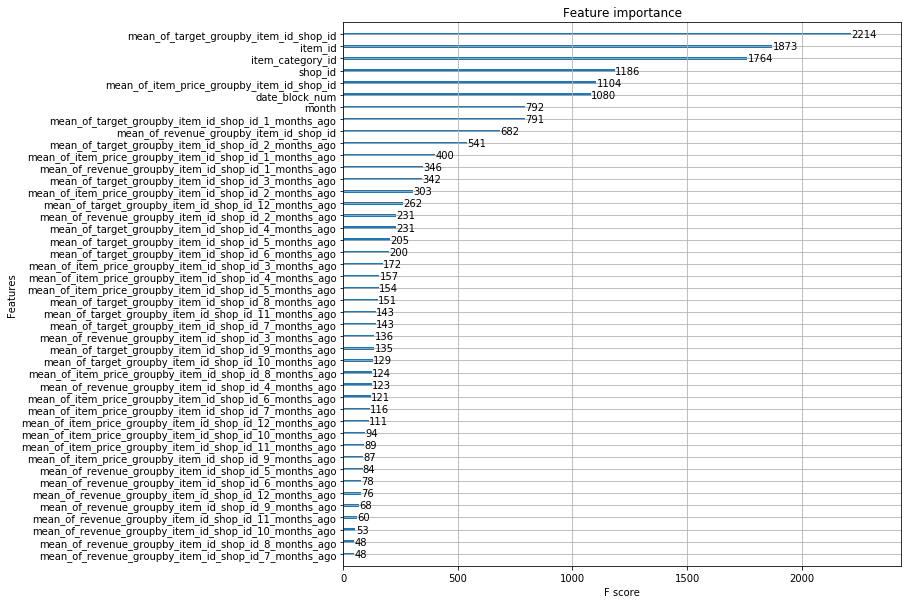

In [69]:
fig, ax = pyplot.subplots(figsize=(10,10))
xgb.plot_importance(model,ax=ax)